# Medical Equipment Cost Prediction - Linear Regression

This notebook performs linear regression with proper data preprocessing including:
- Missing data handling
- Outlier detection and treatment
- Feature engineering
- Model evaluation

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load the training data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nFirst few rows:")
train_df.head()

Training data shape: (5000, 20)
Test data shape: (500, 19)

First few rows:


,Hospital_Id,Supplier_Name,Supplier_Reliability,Equipment_Height,Equipment_Width,Equipment_Weight,Equipment_Type,Equipment_Value,Base_Transport_Fee,CrossBorder_Shipping,Urgent_Shipping,Installation_Service,Transport_Method,Fragile_Equipment,Hospital_Info,Rural_Hospital,Order_Placed_Date,Delivery_Date,Hospital_Location,Transport_Cost
0,fffe3200360030003700,Jo Valencia,0.44,21.0,6.0,NaN,NaN,3.62,17.13,No,No,No,Roadways,No,Working Class,No,10/20/17,10/20/17,APO AA 33776,179.50
1,fffe3400380037003400,Wanda Warren,0.58,29.0,20.0,1210684.0,Marble,9703.37,35.42,No,Yes,Yes,Roadways,No,Working Class,No,02/22/16,02/24/16,"South Kevin, VT 84493",627732.45
2,fffe3200350036003700,Robert Ackies,0.97,39.0,15.0,3305.0,Aluminium,40.21,18.54,No,No,No,Roadways,No,Working Class,No,01/11/18,01/10/18,"Kevinshire, NE 31279",1565.92
3,fffe3800320034003400,Charlotte Membreno,0.70,8.0,5.0,606.0,Brass,4.55,17.48,No,No,No,Roadways,No,Working Class,No,08/06/16,08/06/16,DPO AP 61572,257.71
4,fffe3600340033003000,Nena Silva,0.66,27.0,13.0,NaN,Marble,2726.80,30.23,Yes,No,No,Roadways,No,Working Class,NaN,12/15/16,12/17/16,"Joshuamouth, AK 01550",8553.52


## 3. Data Exploration

In [3]:
# Basic information
print("Dataset Info:")
print(train_df.info())
print("\n" + "="*80)
print("\nBasic Statistics:")
print(train_df.describe())
print("\n" + "="*80)
print("\nTarget Variable Statistics:")
print(train_df['Transport_Cost'].describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hospital_Id           5000 non-null   object 
 1   Supplier_Name         5000 non-null   object 
 2   Supplier_Reliability  4413 non-null   float64
 3   Equipment_Height      4717 non-null   float64
 4   Equipment_Width       4557 non-null   float64
 5   Equipment_Weight      4540 non-null   float64
 6   Equipment_Type        4401 non-null   object 
 7   Equipment_Value       5000 non-null   float64
 8   Base_Transport_Fee    5000 non-null   float64
 9   CrossBorder_Shipping  5000 non-null   object 
 10  Urgent_Shipping       5000 non-null   object 
 11  Installation_Service  5000 non-null   object 
 12  Transport_Method      3929 non-null   object 
 13  Fragile_Equipment     5000 non-null   object 
 14  Hospital_Info         5000 non-null   object 
 15  Rural_H

In [4]:
# Check for missing values
print("Missing Values Count:")
missing_counts = train_df.isnull().sum()
missing_percentage = (missing_counts / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Percentage': missing_percentage
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

Missing Values Count:
                      Missing_Count  Percentage
Transport_Method               1071       21.42
Equipment_Type                  599       11.98
Supplier_Reliability            587       11.74
Rural_Hospital                  586       11.72
Equipment_Weight                460        9.20
Equipment_Width                 443        8.86
Equipment_Height                283        5.66


## 4. Handle Missing Data

In [5]:
# Create a copy for preprocessing
train_clean = train_df.copy()
test_clean = test_df.copy()

# Identify numerical and categorical columns
numerical_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_clean.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from numerical columns
if 'Transport_Cost' in numerical_cols:
    numerical_cols.remove('Transport_Cost')

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols[:5]}...")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")

# Handle missing values in numerical columns - use median
for col in numerical_cols:
    if train_clean[col].isnull().sum() > 0:
        median_val = train_clean[col].median()
        train_clean[col].fillna(median_val, inplace=True)
        test_clean[col].fillna(median_val, inplace=True)
        print(f"Filled {col} with median: {median_val:.2f}")

# Handle missing values in categorical columns - use mode
for col in categorical_cols:
    if train_clean[col].isnull().sum() > 0:
        mode_val = train_clean[col].mode()[0] if len(train_clean[col].mode()) > 0 else 'Unknown'
        train_clean[col].fillna(mode_val, inplace=True)
        test_clean[col].fillna(mode_val, inplace=True)
        print(f"Filled {col} with mode: {mode_val}")

print(f"\nMissing values after handling: {train_clean.isnull().sum().sum()}")

Numerical columns (6): ['Supplier_Reliability', 'Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Equipment_Value']...
Categorical columns (13): ['Hospital_Id', 'Supplier_Name', 'Equipment_Type', 'CrossBorder_Shipping', 'Urgent_Shipping']...
Filled Supplier_Reliability with median: 0.45
Filled Equipment_Height with median: 20.00
Filled Equipment_Width with median: 8.00
Filled Equipment_Weight with median: 3137.50
Filled Equipment_Type with mode: Aluminium
Filled Transport_Method with mode: Roadways
Filled Rural_Hospital with mode: No

Missing values after handling: 0


## 5. Detect and Handle Outliers

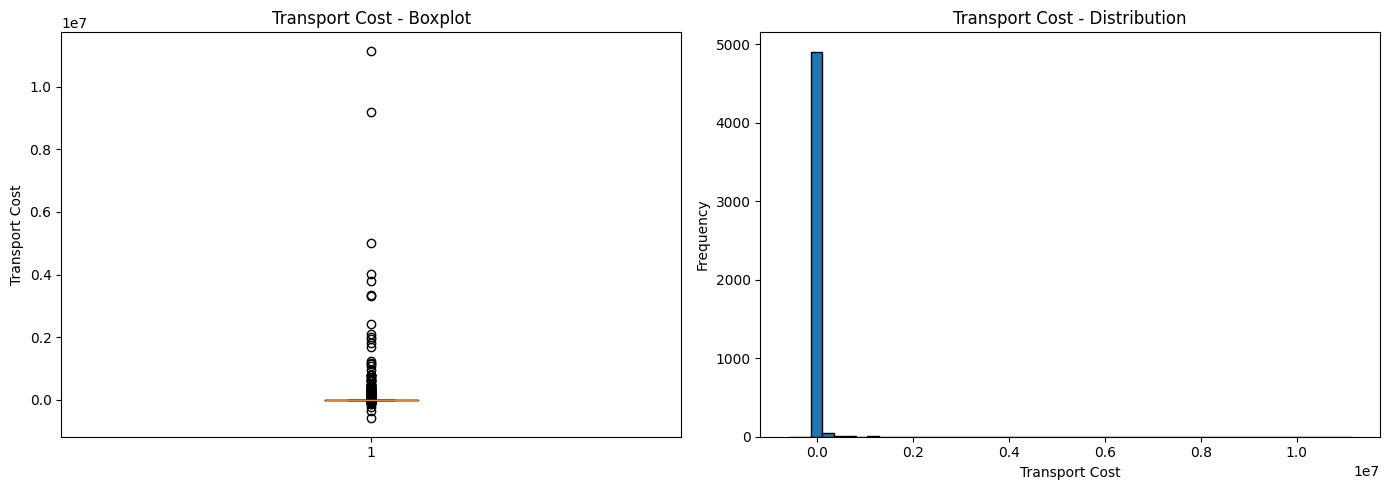

Transport Cost Statistics:
Mean: 17898.06
Median: 377.61
Std: 255426.13


In [6]:
# Visualize outliers in target variable
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
axes[0].boxplot(train_clean['Transport_Cost'])
axes[0].set_title('Transport Cost - Boxplot')
axes[0].set_ylabel('Transport Cost')

# Histogram
axes[1].hist(train_clean['Transport_Cost'], bins=50, edgecolor='black')
axes[1].set_title('Transport Cost - Distribution')
axes[1].set_xlabel('Transport Cost')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Transport Cost Statistics:")
print(f"Mean: {train_clean['Transport_Cost'].mean():.2f}")
print(f"Median: {train_clean['Transport_Cost'].median():.2f}")
print(f"Std: {train_clean['Transport_Cost'].std():.2f}")

In [7]:
# Detect outliers using IQR method for numerical features
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check outliers in target variable
outliers, lower, upper = detect_outliers_iqr(train_clean, 'Transport_Cost')
print(f"Outliers in Transport_Cost: {len(outliers)} ({len(outliers)/len(train_clean)*100:.2f}%)")
print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")

# Handle outliers using capping (Winsorization)
print("\nHandling outliers using capping method...")
train_clean['Transport_Cost'] = np.where(
    train_clean['Transport_Cost'] > upper, 
    upper, 
    train_clean['Transport_Cost']
)
train_clean['Transport_Cost'] = np.where(
    train_clean['Transport_Cost'] < lower, 
    lower, 
    train_clean['Transport_Cost']
)

print(f"After capping - Min: {train_clean['Transport_Cost'].min():.2f}, Max: {train_clean['Transport_Cost'].max():.2f}")

Outliers in Transport_Cost: 914 (18.28%)
Lower bound: -1303.02, Upper bound: 2674.13

Handling outliers using capping method...
After capping - Min: -1303.02, Max: 2674.13


## 6. Feature Engineering

In [8]:
# Convert date columns to datetime
train_clean['Order_Placed_Date'] = pd.to_datetime(train_clean['Order_Placed_Date'])
train_clean['Delivery_Date'] = pd.to_datetime(train_clean['Delivery_Date'])
test_clean['Order_Placed_Date'] = pd.to_datetime(test_clean['Order_Placed_Date'])
test_clean['Delivery_Date'] = pd.to_datetime(test_clean['Delivery_Date'])

# Create new features
train_clean['Delivery_Days'] = (train_clean['Delivery_Date'] - train_clean['Order_Placed_Date']).dt.days
test_clean['Delivery_Days'] = (test_clean['Delivery_Date'] - test_clean['Order_Placed_Date']).dt.days

# Create equipment volume feature
train_clean['Equipment_Volume'] = train_clean['Equipment_Height'] * train_clean['Equipment_Width']
test_clean['Equipment_Volume'] = test_clean['Equipment_Height'] * test_clean['Equipment_Width']

# Drop date columns as they are not needed for regression
train_clean = train_clean.drop(['Order_Placed_Date', 'Delivery_Date'], axis=1)
test_clean = test_clean.drop(['Order_Placed_Date', 'Delivery_Date'], axis=1)

print("New features created:")
print("- Delivery_Days")
print("- Equipment_Volume")
print(f"\nUpdated shape: {train_clean.shape}")

New features created:
- Delivery_Days
- Equipment_Volume

Updated shape: (5000, 20)


## 7. Encode Categorical Variables

In [9]:
# Get categorical columns (excluding IDs and location which are too many unique values)
categorical_to_encode = ['Supplier_Name', 'Equipment_Type', 'CrossBorder_Shipping', 
                         'Urgent_Shipping', 'Installation_Service', 'Transport_Method',
                         'Fragile_Equipment', 'Hospital_Info', 'Rural_Hospital']

# Use Label Encoding for categorical variables
label_encoders = {}
for col in categorical_to_encode:
    if col in train_clean.columns:
        le = LabelEncoder()
        # Fit on combined data to ensure same encoding
        combined = pd.concat([train_clean[col].astype(str), test_clean[col].astype(str)])
        le.fit(combined)
        train_clean[col] = le.transform(train_clean[col].astype(str))
        test_clean[col] = le.transform(test_clean[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")

# Drop high cardinality columns that won't help regression
cols_to_drop = ['Hospital_Id', 'Hospital_Location']
train_clean = train_clean.drop(cols_to_drop, axis=1)
test_clean = test_clean.drop(cols_to_drop, axis=1)

print(f"\nFinal shape after encoding: {train_clean.shape}")

Encoded Supplier_Name: 5461 unique values
Encoded Equipment_Type: 7 unique values
Encoded CrossBorder_Shipping: 2 unique values
Encoded Urgent_Shipping: 2 unique values
Encoded Installation_Service: 2 unique values
Encoded Transport_Method: 3 unique values
Encoded Fragile_Equipment: 2 unique values
Encoded Hospital_Info: 2 unique values
Encoded Rural_Hospital: 2 unique values

Final shape after encoding: (5000, 18)


## 8. Prepare Data for Modeling

In [10]:
# Separate features and target
X = train_clean.drop('Transport_Cost', axis=1)
y = train_clean['Transport_Cost']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"\nFeatures used for modeling: {X.shape[1]}")
print(f"Feature names: {list(X.columns)}")

Training set size: (4000, 17)
Validation set size: (1000, 17)

Features used for modeling: 17
Feature names: ['Supplier_Name', 'Supplier_Reliability', 'Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Equipment_Type', 'Equipment_Value', 'Base_Transport_Fee', 'CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service', 'Transport_Method', 'Fragile_Equipment', 'Hospital_Info', 'Rural_Hospital', 'Delivery_Days', 'Equipment_Volume']


## 9. Train Linear Regression Model

In [11]:
# Initialize and train Linear Regression model
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Model training completed!")

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

print("\nModel coefficients (top 10):")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(feature_importance.head(10))

Training Linear Regression model...
Model training completed!

Model coefficients (top 10):
                 Feature  Coefficient
1   Supplier_Reliability  1005.594409
12     Fragile_Equipment   -67.175994
11      Transport_Method   -46.866133
3        Equipment_Width    45.856504
5         Equipment_Type    42.496462
13         Hospital_Info   -40.811910
9        Urgent_Shipping    31.602874
14        Rural_Hospital    31.010854
10  Installation_Service    17.916529
8   CrossBorder_Shipping    17.410422


## 10. Model Evaluation - Performance Metrics

In [ ]:
# Calculate evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

# Display results
print("="*60)
print("LINEAR REGRESSION MODEL - PERFORMANCE METRICS")
print("="*60)
print("\nTRAINING SET METRICS:")
print(f"  R² Score (R-squared):        {train_r2:.4f}")
print(f"  RMSE (Root Mean Squared Error): {train_rmse:.2f}")
print(f"  MAE (Mean Absolute Error):   {train_mae:.2f}")

print("\nVALIDATION SET METRICS:")
print(f"  R² Score (R-squared):        {val_r2:.4f}")
print(f"  RMSE (Root Mean Squared Error): {val_rmse:.2f}")
print(f"  MAE (Mean Absolute Error):   {val_mae:.2f}")

print("\n" + "="*60)
print(f"FINAL SCORE (Validation R²): {val_r2:.4f}")
print("="*60)

# Check for overfitting
print(f"\nOverfitting Check:")
print(f"  Difference in R²: {abs(train_r2 - val_r2):.4f}")
if abs(train_r2 - val_r2) < 0.05:
    print("  Status: Good - Minimal overfitting")
elif abs(train_r2 - val_r2) < 0.10:
    print("  Status: Moderate - Some overfitting")
else:
    print("  Status: High - Significant overfitting")

LINEAR REGRESSION MODEL - PERFORMANCE METRICS

TRAINING SET METRICS:
  R² Score (R-squared):        0.3877
  RMSE (Root Mean Squared Error): 795.41
  MAE (Mean Absolute Error):   516.64

VALIDATION SET METRICS:
  R² Score (R-squared):        0.3648
  RMSE (Root Mean Squared Error): 787.48
  MAE (Mean Absolute Error):   515.31

FINAL SCORE (Validation R²): 0.3648

Overfitting Check:
  Difference in R²: 0.0229
  Status: Good - Minimal overfitting


In [ ]:
RMSE (Root Mean Squared Error): {train_rmse:.2f}")
print(f"  MAE (Mean Absolute Error):   {train_mae:.2f}")

print("\nVALIDATION SET METRICS:")
print(f"  R² Score (R-squared):        {val_r2:.4f}")
print(f"  RMSE (Root Mean Squared Error): {val_rmse:.2f}")
print(f"  MAE (Mean Absolute Error):   {val_mae:.2f}")

print("\n" + "="*60)
print(f"FINAL SCORE (Validation R²): {val_r2:.4f}")
print("="*60)

# Check for overfitting
print(f"\nOverfitting Check:")
print(f"  Difference in R²: {abs(train_r2 - val_r2):.4f}")
if abs(train_r2 - val_r2) < 0.05:
    print("  Status: Good - Minimal overfitting")
elif abs(train_r2 - val_r2) < 0.10:
    print("  Status: Moderate - Some overfitting")
else:
    print("  Status: High - Significant overfitting")

## 11. Visualize Predictions

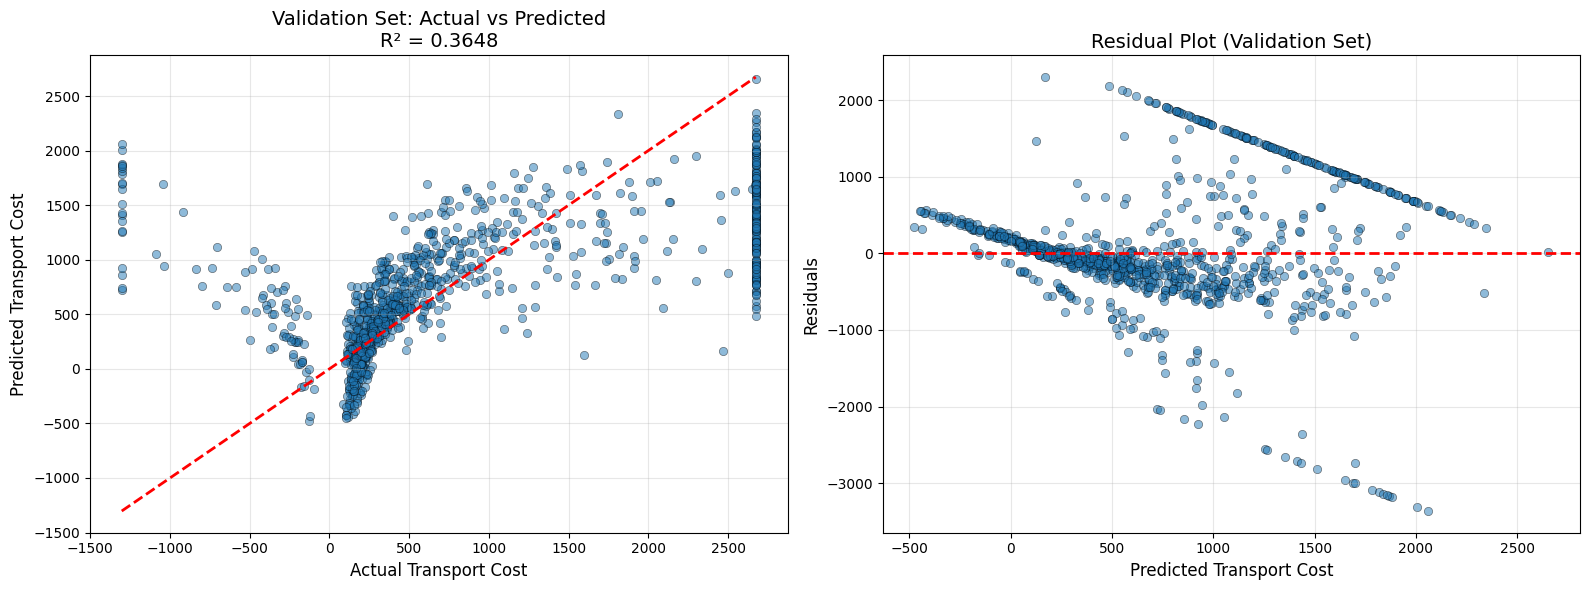

In [13]:
# Visualization of predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot - Validation Set
axes[0].scatter(y_val, y_val_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Transport Cost', fontsize=12)
axes[0].set_ylabel('Predicted Transport Cost', fontsize=12)
axes[0].set_title(f'Validation Set: Actual vs Predicted\nR² = {val_r2:.4f}', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_val - y_val_pred
axes[1].scatter(y_val_pred, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Transport Cost', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot (Validation Set)', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11.1 Generate Submission for Linear Regression

In [14]:


print("Generating submission file for Linear Regression...")

# Predict on the preprocessed test data (test_clean)
# 'test_clean' is ready from Section 7
test_predictions_lr = lr_model.predict(test_clean)

# Create the submission DataFrame
# Use the 'Hospital_Id' from the original 'test_df'
submission_lr = pd.DataFrame({
    'Hospital_Id': test_df['Hospital_Id'], 
    'Transport_Cost': test_predictions_lr
})

# Save to CSV
submission_lr.to_csv('submission_linear_regression.csv', index=False)

print("✅ submission_linear_regression.csv created successfully!")
print(submission_lr.head())

Generating submission file for Linear Regression...
✅ submission_linear_regression.csv created successfully!
            Hospital_Id  Transport_Cost
0          fffe33003400      617.796535
1  fffe3700330036003600      884.214033
2  fffe3300390038003400     1587.723705
3      fffe310030003900       93.725014
4  fffe3700330031003200     1066.495545


## 12. Summary of Results

In [15]:
# Create a comprehensive summary
summary = {
    'Data Preprocessing': {
        'Original Training Samples': len(train_df),
        'Features Used': X.shape[1],
        'Missing Values Handled': 'Yes (Median for numerical, Mode for categorical)',
        'Outliers Handled': 'Yes (IQR capping method)',
        'Feature Engineering': 'Delivery_Days, Equipment_Volume'
    },
    'Model Performance': {
        'Training R² Score': f'{train_r2:.4f}',
        'Validation R² Score': f'{val_r2:.4f}',
        'Training RMSE': f'{train_rmse:.2f}',
        'Validation RMSE': f'{val_rmse:.2f}',
        'Training MAE': f'{train_mae:.2f}',
        'Validation MAE': f'{val_mae:.2f}'
    }
}

print("\n" + "="*70)
print("MEDICAL EQUIPMENT COST PREDICTION - LINEAR REGRESSION SUMMARY")
print("="*70)

for section, metrics in summary.items():
    print(f"\n{section}:")
    print("-" * 70)
    for key, value in metrics.items():
        print(f"  {key:.<50} {value}")

print("\n" + "="*70)
print(f"FINAL MODEL SCORE (Validation R²): {val_r2:.4f}")
print("="*70)

print("\nInterpretation:")
print(f"  - The model explains {val_r2*100:.2f}% of the variance in Transport Cost")
print(f"  - Average prediction error (MAE): ±{val_mae:.2f} units")
print(f"  - Root mean squared error (RMSE): {val_rmse:.2f} units")


MEDICAL EQUIPMENT COST PREDICTION - LINEAR REGRESSION SUMMARY

Data Preprocessing:
----------------------------------------------------------------------
  Original Training Samples......................... 5000
  Features Used..................................... 17
  Missing Values Handled............................ Yes (Median for numerical, Mode for categorical)
  Outliers Handled.................................. Yes (IQR capping method)
  Feature Engineering............................... Delivery_Days, Equipment_Volume

Model Performance:
----------------------------------------------------------------------
  Training R² Score................................. 0.3877
  Validation R² Score............................... 0.3648
  Training RMSE..................................... 795.41
  Validation RMSE................................... 787.48
  Training MAE...................................... 516.64
  Validation MAE.................................... 515.31

FINAL MODEL SC

## 13. Polynomial Regression with Hyperparameter Tuning

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

print("Testing Polynomial Regression with degrees from 1 to 5...")
print("="*70)

# Store results for each degree
poly_results = {
    'degree': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': [],
    'train_mae': [],
    'val_mae': []
}

# Test polynomial degrees from 1 to 10
for degree in range(1, 6):
    print(f"\nTesting Polynomial Degree: {degree}")
    
    # Create polynomial features and model pipeline
    poly_model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear_regression', LinearRegression())
    ])
    
    # Train the model
    poly_model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred_poly = poly_model.predict(X_train)
    y_val_pred_poly = poly_model.predict(X_val)
    
    # Calculate metrics
    train_r2_poly = r2_score(y_train, y_train_pred_poly)
    val_r2_poly = r2_score(y_val, y_val_pred_poly)
    train_rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
    val_rmse_poly = np.sqrt(mean_squared_error(y_val, y_val_pred_poly))
    train_mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
    val_mae_poly = mean_absolute_error(y_val, y_val_pred_poly)
    
    # Store results
    poly_results['degree'].append(degree)
    poly_results['train_r2'].append(train_r2_poly)
    poly_results['val_r2'].append(val_r2_poly)
    poly_results['train_rmse'].append(train_rmse_poly)
    poly_results['val_rmse'].append(val_rmse_poly)
    poly_results['train_mae'].append(train_mae_poly)
    poly_results['val_mae'].append(val_mae_poly)
    
    print(f"  Train R²: {train_r2_poly:.4f} | Val R²: {val_r2_poly:.4f}")
    print(f"  Train RMSE: {train_rmse_poly:.2f} | Val RMSE: {val_rmse_poly:.2f}")

print("\n" + "="*70)
print("Hyperparameter tuning completed!")

Testing Polynomial Regression with degrees from 1 to 5...

Testing Polynomial Degree: 1
  Train R²: 0.3877 | Val R²: 0.3648
  Train RMSE: 795.41 | Val RMSE: 787.48

Testing Polynomial Degree: 2
  Train R²: 0.4150 | Val R²: 0.3625
  Train RMSE: 777.47 | Val RMSE: 788.93

Testing Polynomial Degree: 3
  Train R²: 0.1139 | Val R²: 0.0854
  Train RMSE: 956.90 | Val RMSE: 944.96

Testing Polynomial Degree: 4
  Train R²: 0.0524 | Val R²: 0.0022
  Train RMSE: 989.52 | Val RMSE: 987.01

Testing Polynomial Degree: 5
  Train R²: 0.0231 | Val R²: 0.0079
  Train RMSE: 1004.70 | Val RMSE: 984.16

Hyperparameter tuning completed!


## 14. Visualize Polynomial Degree Performance

Polynomial Regression Results:
 degree  train_r2   val_r2  train_rmse   val_rmse  train_mae    val_mae
      1  0.387739 0.364825  795.405277 787.478901 516.641729 515.310741
      2  0.415033 0.362480  777.473913 788.930951 490.793042 496.198993
      3  0.113888 0.085370  956.895439 944.963210 731.608000 714.096268
      4  0.052436 0.002174  989.519947 987.005756 773.588372 762.668845
      5  0.023140 0.007911 1004.700263 984.164369 791.828872 771.966169


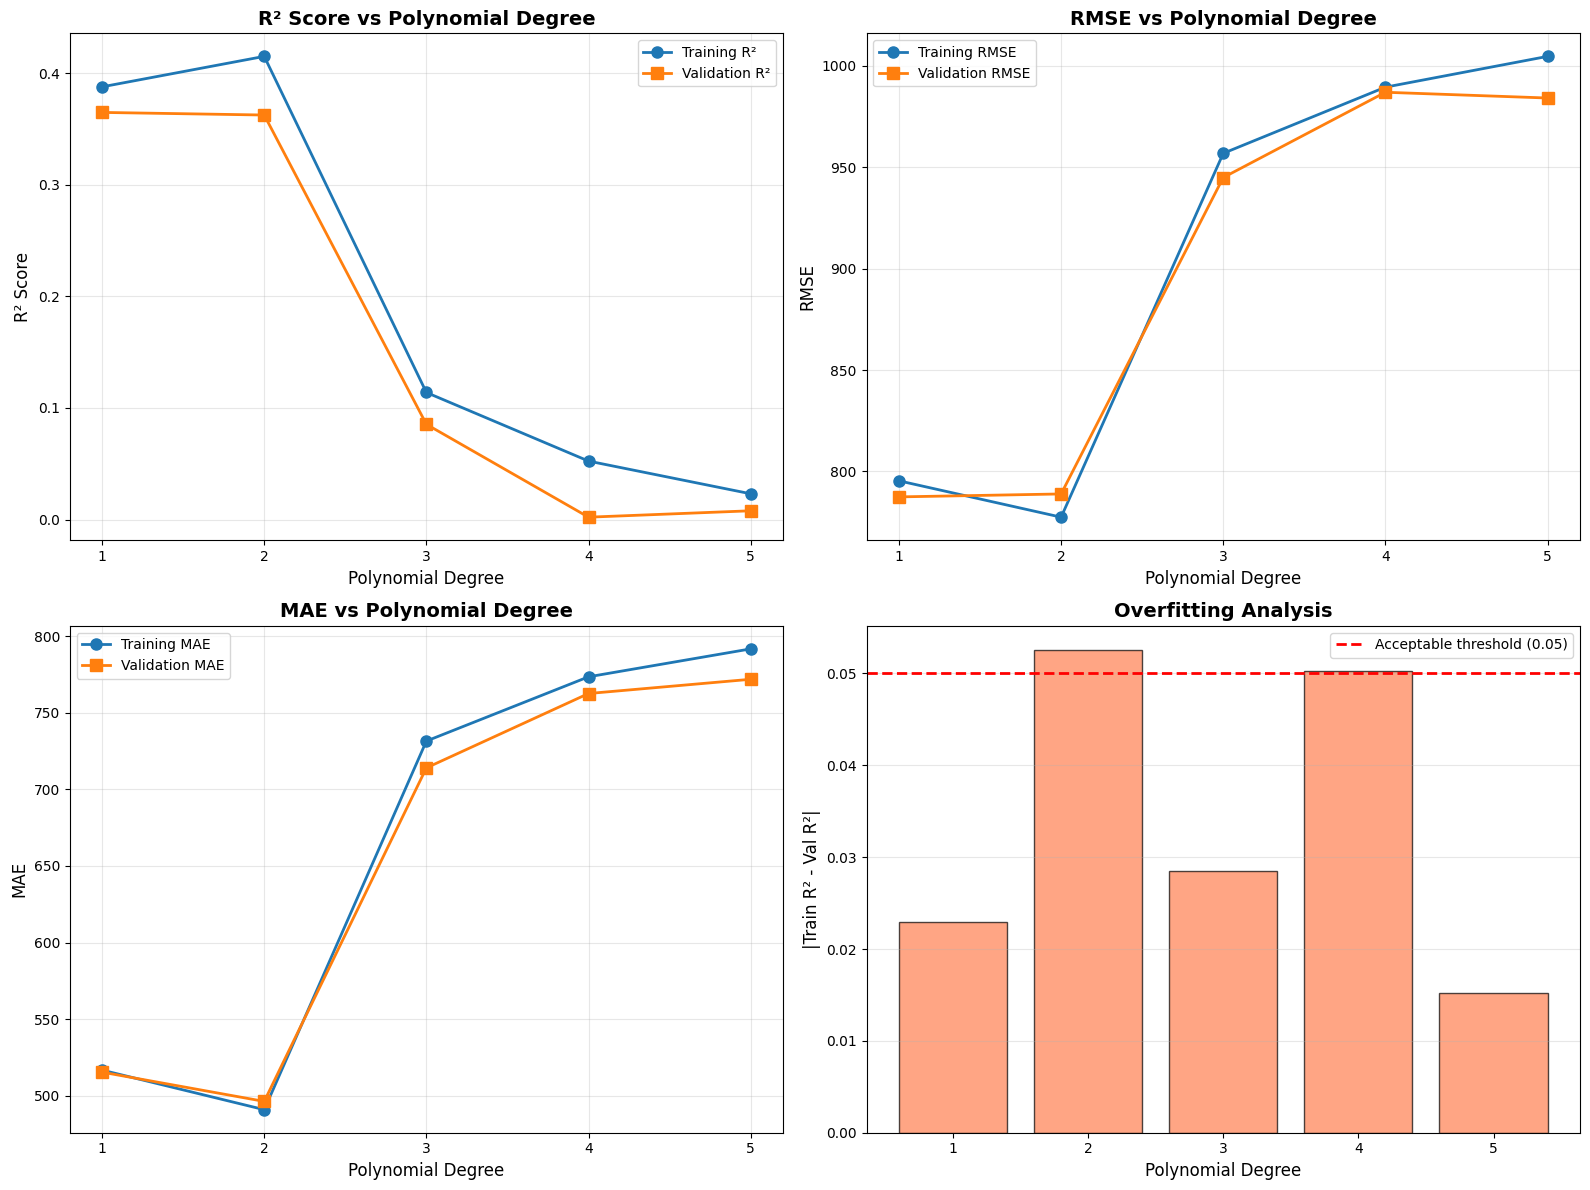

In [17]:
# Create results dataframe
poly_results_df = pd.DataFrame(poly_results)
print("Polynomial Regression Results:")
print(poly_results_df.to_string(index=False))

# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: R² Score vs Degree
axes[0, 0].plot(poly_results_df['degree'], poly_results_df['train_r2'], 
                marker='o', label='Training R²', linewidth=2, markersize=8)
axes[0, 0].plot(poly_results_df['degree'], poly_results_df['val_r2'], 
                marker='s', label='Validation R²', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Polynomial Degree', fontsize=12)
axes[0, 0].set_ylabel('R² Score', fontsize=12)
axes[0, 0].set_title('R² Score vs Polynomial Degree', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(1, 6))

# Plot 2: RMSE vs Degree
axes[0, 1].plot(poly_results_df['degree'], poly_results_df['train_rmse'], 
                marker='o', label='Training RMSE', linewidth=2, markersize=8)
axes[0, 1].plot(poly_results_df['degree'], poly_results_df['val_rmse'], 
                marker='s', label='Validation RMSE', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Polynomial Degree', fontsize=12)
axes[0, 1].set_ylabel('RMSE', fontsize=12)
axes[0, 1].set_title('RMSE vs Polynomial Degree', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(1, 6))

# Plot 3: MAE vs Degree
axes[1, 0].plot(poly_results_df['degree'], poly_results_df['train_mae'], 
                marker='o', label='Training MAE', linewidth=2, markersize=8)
axes[1, 0].plot(poly_results_df['degree'], poly_results_df['val_mae'], 
                marker='s', label='Validation MAE', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Polynomial Degree', fontsize=12)
axes[1, 0].set_ylabel('MAE', fontsize=12)
axes[1, 0].set_title('MAE vs Polynomial Degree', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(1, 6))

# Plot 4: Overfitting Analysis (Train vs Val R² difference)
r2_diff = [abs(t - v) for t, v in zip(poly_results_df['train_r2'], poly_results_df['val_r2'])]
axes[1, 1].bar(poly_results_df['degree'], r2_diff, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].axhline(y=0.05, color='red', linestyle='--', label='Acceptable threshold (0.05)', linewidth=2)
axes[1, 1].set_xlabel('Polynomial Degree', fontsize=12)
axes[1, 1].set_ylabel('|Train R² - Val R²|', fontsize=12)
axes[1, 1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(range(1, 6))

plt.tight_layout()
plt.show()

## 15. Select Best Polynomial Degree

In [18]:
# Find the best polynomial degree based on validation R²
best_idx = poly_results_df['val_r2'].idxmax()
best_degree = poly_results_df.loc[best_idx, 'degree']
best_val_r2 = poly_results_df.loc[best_idx, 'val_r2']
best_val_rmse = poly_results_df.loc[best_idx, 'val_rmse']
best_val_mae = poly_results_df.loc[best_idx, 'val_mae']
best_train_r2 = poly_results_df.loc[best_idx, 'train_r2']

print("="*70)
print("BEST POLYNOMIAL DEGREE SELECTION")
print("="*70)
print(f"\nBest Polynomial Degree: {best_degree}")
print(f"\nPerformance Metrics:")
print(f"  Validation R² Score:  {best_val_r2:.4f}")
print(f"  Training R² Score:    {best_train_r2:.4f}")
print(f"  Validation RMSE:      {best_val_rmse:.2f}")
print(f"  Validation MAE:       {best_val_mae:.2f}")
print(f"  Overfitting Gap:      {abs(best_train_r2 - best_val_r2):.4f}")

# Compare with linear regression (degree 1)
linear_val_r2 = poly_results_df.loc[0, 'val_r2']
improvement = ((best_val_r2 - linear_val_r2) / linear_val_r2) * 100

print(f"\n" + "="*70)
print("COMPARISON WITH LINEAR REGRESSION")
print("="*70)
print(f"Linear Regression (Degree 1) Val R²:  {linear_val_r2:.4f}")
print(f"Best Polynomial (Degree {best_degree}) Val R²:   {best_val_r2:.4f}")
print(f"Improvement:                           {improvement:+.2f}%")
print("="*70)

BEST POLYNOMIAL DEGREE SELECTION

Best Polynomial Degree: 1

Performance Metrics:
  Validation R² Score:  0.3648
  Training R² Score:    0.3877
  Validation RMSE:      787.48
  Validation MAE:       515.31
  Overfitting Gap:      0.0229

COMPARISON WITH LINEAR REGRESSION
Linear Regression (Degree 1) Val R²:  0.3648
Best Polynomial (Degree 1) Val R²:   0.3648
Improvement:                           +0.00%


## 16. Train Final Best Polynomial Model

In [19]:
# Train final model with best degree
print(f"Training final Polynomial Regression model with degree {best_degree}...")

best_poly_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=int(best_degree), include_bias=False)),
    ('linear_regression', LinearRegression())
])

best_poly_model.fit(X_train, y_train)

# Make predictions
y_train_pred_best = best_poly_model.predict(X_train)
y_val_pred_best = best_poly_model.predict(X_val)

# Calculate final metrics
final_train_r2 = r2_score(y_train, y_train_pred_best)
final_val_r2 = r2_score(y_val, y_val_pred_best)
final_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
final_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_best))
final_train_mae = mean_absolute_error(y_train, y_train_pred_best)
final_val_mae = mean_absolute_error(y_val, y_val_pred_best)

print("Model training completed!")
print(f"\nNumber of polynomial features created: {best_poly_model.named_steps['poly_features'].n_output_features_}")

print("\n" + "="*70)
print(f"POLYNOMIAL REGRESSION (Degree {int(best_degree)}) - FINAL PERFORMANCE METRICS")
print("="*70)
print("\nTRAINING SET METRICS:")
print(f"  R² Score:  {final_train_r2:.4f}")
print(f"  RMSE:      {final_train_rmse:.2f}")
print(f"  MAE:       {final_train_mae:.2f}")

print("\nVALIDATION SET METRICS:")
print(f"  R² Score:  {final_val_r2:.4f}")
print(f"  RMSE:      {final_val_rmse:.2f}")
print(f"  MAE:       {final_val_mae:.2f}")

print("\n" + "="*70)
print(f"FINAL SCORE (Validation R²): {final_val_r2:.4f}")
print("="*70)

Training final Polynomial Regression model with degree 1...
Model training completed!

Number of polynomial features created: 17

POLYNOMIAL REGRESSION (Degree 1) - FINAL PERFORMANCE METRICS

TRAINING SET METRICS:
  R² Score:  0.3877
  RMSE:      795.41
  MAE:       516.64

VALIDATION SET METRICS:
  R² Score:  0.3648
  RMSE:      787.48
  MAE:       515.31

FINAL SCORE (Validation R²): 0.3648


## 17. Visualize Best Polynomial Model Predictions

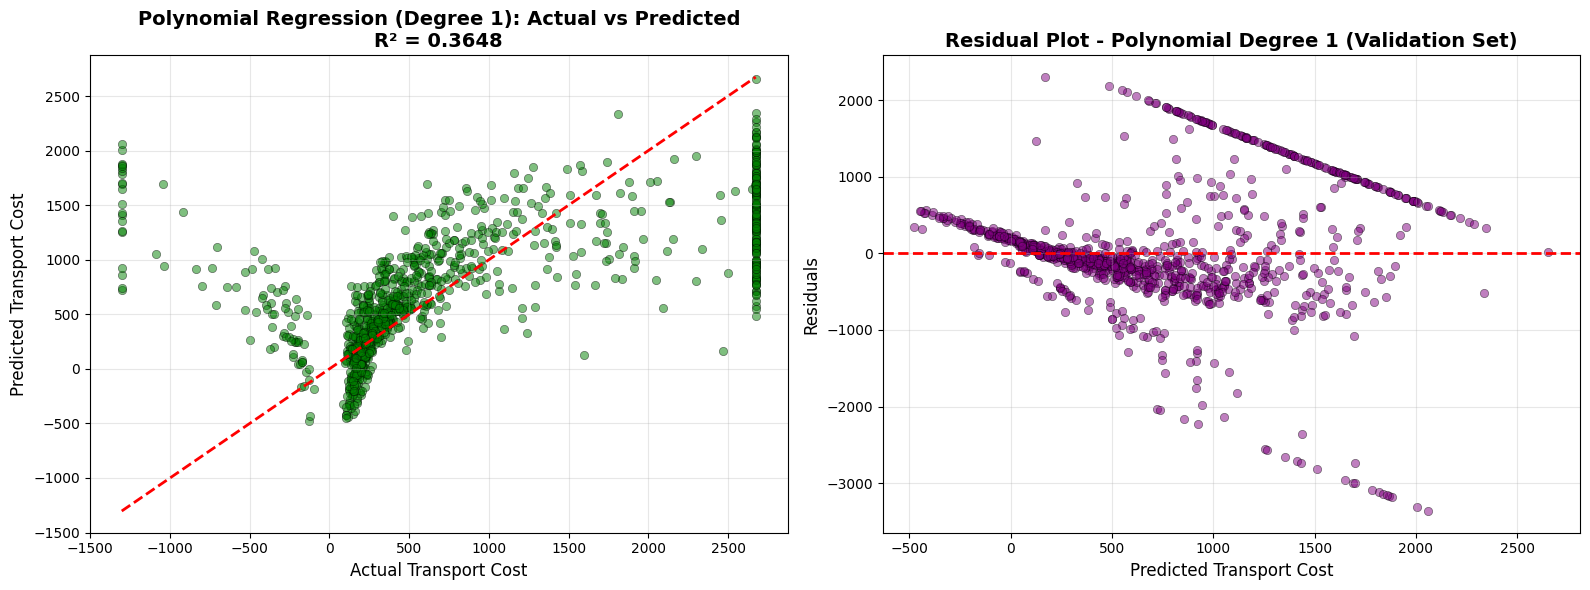


Residual Statistics:
  Mean of Residuals:     45.1050
  Std of Residuals:      786.58
  Min Residual:          -3364.10
  Max Residual:          2301.88


In [20]:
# Visualization of best polynomial model predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot - Validation Set
axes[0].scatter(y_val, y_val_pred_best, alpha=0.5, edgecolors='k', linewidth=0.5, color='green')
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Transport Cost', fontsize=12)
axes[0].set_ylabel('Predicted Transport Cost', fontsize=12)
axes[0].set_title(f'Polynomial Regression (Degree {int(best_degree)}): Actual vs Predicted\nR² = {final_val_r2:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals_poly = y_val - y_val_pred_best
axes[1].scatter(y_val_pred_best, residuals_poly, alpha=0.5, edgecolors='k', linewidth=0.5, color='purple')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Transport Cost', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title(f'Residual Plot - Polynomial Degree {int(best_degree)} (Validation Set)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print residual statistics
print("\nResidual Statistics:")
print(f"  Mean of Residuals:     {residuals_poly.mean():.4f}")
print(f"  Std of Residuals:      {residuals_poly.std():.2f}")
print(f"  Min Residual:          {residuals_poly.min():.2f}")
print(f"  Max Residual:          {residuals_poly.max():.2f}")

## 18. Final Comparison: Linear vs Polynomial Regression

In [21]:
# Create comprehensive comparison
comparison_data = {
    'Model': ['Linear Regression', f'Polynomial Regression (Degree {int(best_degree)})'],
    'Train R²': [train_r2, final_train_r2],
    'Validation R²': [val_r2, final_val_r2],
    'Train RMSE': [train_rmse, final_train_rmse],
    'Validation RMSE': [val_rmse, final_val_rmse],
    'Train MAE': [train_mae, final_train_mae],
    'Validation MAE': [val_mae, final_val_mae],
    'Overfitting Gap': [abs(train_r2 - val_r2), abs(final_train_r2 - final_val_r2)]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print("FINAL MODEL COMPARISON: LINEAR vs POLYNOMIAL REGRESSION")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Determine the best model
if final_val_r2 > val_r2:
    winner = f'Polynomial Regression (Degree {int(best_degree)})'
    improvement_pct = ((final_val_r2 - val_r2) / val_r2) * 100
    print(f"\n🏆 WINNER: {winner}")
    print(f"   Improvement over Linear Regression: {improvement_pct:.2f}%")
else:
    winner = 'Linear Regression'
    print(f"\n🏆 WINNER: {winner}")
    print("   Linear Regression performs better or equally well.")

print("\n" + "="*90)
print("FINAL RECOMMENDATIONS")
print("="*90)
print(f"✓ Best Model: {winner}")
print(f"✓ Validation R² Score: {max(val_r2, final_val_r2):.4f}")
print(f"✓ Validation RMSE: {min(val_rmse, final_val_rmse):.2f}")
print(f"✓ Validation MAE: {min(val_mae, final_val_mae):.2f}")
print("="*90)


FINAL MODEL COMPARISON: LINEAR vs POLYNOMIAL REGRESSION
                           Model  Train R²  Validation R²  Train RMSE  Validation RMSE  Train MAE  Validation MAE  Overfitting Gap
               Linear Regression  0.387739       0.364825  795.405277       787.478901 516.641729      515.310741         0.022914
Polynomial Regression (Degree 1)  0.387739       0.364825  795.405277       787.478901 516.641729      515.310741         0.022914

🏆 WINNER: Linear Regression
   Linear Regression performs better or equally well.

FINAL RECOMMENDATIONS
✓ Best Model: Linear Regression
✓ Validation R² Score: 0.3648
✓ Validation RMSE: 787.48
✓ Validation MAE: 515.31


## 19. Ridge Regression with Hyperparameter Tuning

In [22]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Use polynomial features from best degree
print(f"Using Polynomial Features with Degree {int(best_degree)} for Regularized Models")
print("="*70)

# Create polynomial features
poly_features = PolynomialFeatures(degree=int(best_degree), include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.transform(X_val)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")

# Ridge Regression - Hyperparameter Tuning
print("\n" + "="*70)
print("RIDGE REGRESSION - HYPERPARAMETER TUNING")
print("="*70)

# Define alpha values to test
ridge_alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ridge_results = {
    'alpha': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': [],
    'train_mae': [],
    'val_mae': []
}

for alpha in ridge_alphas:
    ridge_model = Ridge(alpha=alpha, random_state=42)
    ridge_model.fit(X_train_poly, y_train)
    
    y_train_pred_ridge = ridge_model.predict(X_train_poly)
    y_val_pred_ridge = ridge_model.predict(X_val_poly)
    
    train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
    val_r2_ridge = r2_score(y_val, y_val_pred_ridge)
    train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
    val_rmse_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
    train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
    val_mae_ridge = mean_absolute_error(y_val, y_val_pred_ridge)
    
    ridge_results['alpha'].append(alpha)
    ridge_results['train_r2'].append(train_r2_ridge)
    ridge_results['val_r2'].append(val_r2_ridge)
    ridge_results['train_rmse'].append(train_rmse_ridge)
    ridge_results['val_rmse'].append(val_rmse_ridge)
    ridge_results['train_mae'].append(train_mae_ridge)
    ridge_results['val_mae'].append(val_mae_ridge)
    
    print(f"Alpha={alpha:7.3f} | Train R²: {train_r2_ridge:.4f} | Val R²: {val_r2_ridge:.4f}")

ridge_results_df = pd.DataFrame(ridge_results)
best_ridge_idx = ridge_results_df['val_r2'].idxmax()
best_ridge_alpha = ridge_results_df.loc[best_ridge_idx, 'alpha']
best_ridge_val_r2 = ridge_results_df.loc[best_ridge_idx, 'val_r2']

print(f"\nBest Ridge Alpha: {best_ridge_alpha}")
print(f"Best Validation R²: {best_ridge_val_r2:.4f}")

Using Polynomial Features with Degree 1 for Regularized Models
Original features: 17
Polynomial features: 17

RIDGE REGRESSION - HYPERPARAMETER TUNING
Alpha=  0.001 | Train R²: 0.3877 | Val R²: 0.3648
Alpha=  0.010 | Train R²: 0.3877 | Val R²: 0.3648
Alpha=  0.100 | Train R²: 0.3877 | Val R²: 0.3648
Alpha=  1.000 | Train R²: 0.3877 | Val R²: 0.3649
Alpha= 10.000 | Train R²: 0.3876 | Val R²: 0.3658
Alpha=100.000 | Train R²: 0.3827 | Val R²: 0.3676
Alpha=1000.000 | Train R²: 0.3482 | Val R²: 0.3462

Best Ridge Alpha: 100.0
Best Validation R²: 0.3676


## 20. Lasso Regression with Hyperparameter Tuning

In [23]:
# Lasso Regression - Hyperparameter Tuning
print("="*70)
print("LASSO REGRESSION - HYPERPARAMETER TUNING")
print("="*70)

# Define alpha values to test
lasso_alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

lasso_results = {
    'alpha': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': [],
    'train_mae': [],
    'val_mae': []
}

for alpha in lasso_alphas:
    lasso_model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso_model.fit(X_train_poly, y_train)
    
    y_train_pred_lasso = lasso_model.predict(X_train_poly)
    y_val_pred_lasso = lasso_model.predict(X_val_poly)
    
    train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
    val_r2_lasso = r2_score(y_val, y_val_pred_lasso)
    train_rmse_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
    val_rmse_lasso = np.sqrt(mean_squared_error(y_val, y_val_pred_lasso))
    train_mae_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
    val_mae_lasso = mean_absolute_error(y_val, y_val_pred_lasso)
    
    lasso_results['alpha'].append(alpha)
    lasso_results['train_r2'].append(train_r2_lasso)
    lasso_results['val_r2'].append(val_r2_lasso)
    lasso_results['train_rmse'].append(train_rmse_lasso)
    lasso_results['val_rmse'].append(val_rmse_lasso)
    lasso_results['train_mae'].append(train_mae_lasso)
    lasso_results['val_mae'].append(val_mae_lasso)
    
    print(f"Alpha={alpha:7.3f} | Train R²: {train_r2_lasso:.4f} | Val R²: {val_r2_lasso:.4f}")

lasso_results_df = pd.DataFrame(lasso_results)
best_lasso_idx = lasso_results_df['val_r2'].idxmax()
best_lasso_alpha = lasso_results_df.loc[best_lasso_idx, 'alpha']
best_lasso_val_r2 = lasso_results_df.loc[best_lasso_idx, 'val_r2']

print(f"\nBest Lasso Alpha: {best_lasso_alpha}")
print(f"Best Validation R²: {best_lasso_val_r2:.4f}")

LASSO REGRESSION - HYPERPARAMETER TUNING
Alpha=  0.001 | Train R²: 0.3877 | Val R²: 0.3648
Alpha=  0.010 | Train R²: 0.3877 | Val R²: 0.3648
Alpha=  0.100 | Train R²: 0.3877 | Val R²: 0.3649
Alpha=  1.000 | Train R²: 0.3877 | Val R²: 0.3656
Alpha= 10.000 | Train R²: 0.3846 | Val R²: 0.3679
Alpha=100.000 | Train R²: 0.3167 | Val R²: 0.3218
Alpha=1000.000 | Train R²: 0.3012 | Val R²: 0.3055

Best Lasso Alpha: 10.0
Best Validation R²: 0.3679


## 20.1 Train Best Lasso Model and Generate Submission

In [29]:

print("\n" + "="*70)
print("TRAINING FINAL LASSO MODEL (EARLY) & GENERATING FILE")
print("="*70)

# 1. Train the final Lasso model using the best alpha found in Section 20
print(f"Training new Lasso model with best alpha: {best_lasso_alpha}")

# We must create a new model instance with the best alpha
# This is the model you will use for prediction
final_lasso_model_early = Lasso(alpha=best_lasso_alpha, random_state=42, max_iter=10000)
final_lasso_model_early.fit(X_train_poly, y_train)
print("Lasso model training completed.")

# 2. Transform the preprocessed test data using the polynomial features
# 'poly_features' was defined in Section 19
# 'test_clean' is ready from Section 7
print("Transforming test data with polynomial features...")
X_test_poly = poly_features.transform(test_clean)
print(f"Transformed test data to {X_test_poly.shape[1]} polynomial features.")

# 3. Predict using the newly trained Lasso model
test_predictions_lasso = final_lasso_model_early.predict(X_test_poly)

# 4. Create the submission DataFrame
# Use the 'Hospital_Id' from the original 'test_df'
submission_lasso = pd.DataFrame({
    'Hospital_Id': test_df['Hospital_Id'], 
    'Transport_Cost': test_predictions_lasso
})

# 5. Save to CSV
submission_lasso.to_csv('submission_lasso_regression.csv', index=False)

print("✅ submission_lasso_regression.csv created successfully!")
print(submission_lasso.head())
print("="*70)


TRAINING FINAL LASSO MODEL (EARLY) & GENERATING FILE
Training new Lasso model with best alpha: 10.0
Lasso model training completed.
Transforming test data with polynomial features...
Transformed test data to 17 polynomial features.
✅ submission_lasso_regression.csv created successfully!
            Hospital_Id  Transport_Cost
0          fffe33003400      603.477636
1  fffe3700330036003600      834.551903
2  fffe3300390038003400     1602.695080
3      fffe310030003900      106.652623
4  fffe3700330031003200     1022.704120


## 21. ElasticNet Regression with Hyperparameter Tuning

In [26]:
# ElasticNet Regression - Hyperparameter Tuning
print("="*70)
print("ELASTICNET REGRESSION - HYPERPARAMETER TUNING")
print("="*70)

# Define alpha and l1_ratio values to test
elasticnet_alphas = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

elasticnet_results = {
    'alpha': [],
    'l1_ratio': [],
    'train_r2': [],
    'val_r2': [],
    'train_rmse': [],
    'val_rmse': [],
    'train_mae': [],
    'val_mae': []
}

print("\nTesting combinations of alpha and l1_ratio...")
for alpha in elasticnet_alphas:
    for l1_ratio in l1_ratios:
        elasticnet_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=10000)
        elasticnet_model.fit(X_train_poly, y_train)
        
        y_train_pred_en = elasticnet_model.predict(X_train_poly)
        y_val_pred_en = elasticnet_model.predict(X_val_poly)
        
        train_r2_en = r2_score(y_train, y_train_pred_en)
        val_r2_en = r2_score(y_val, y_val_pred_en)
        train_rmse_en = np.sqrt(mean_squared_error(y_train, y_train_pred_en))
        val_rmse_en = np.sqrt(mean_squared_error(y_val, y_val_pred_en))
        train_mae_en = mean_absolute_error(y_train, y_train_pred_en)
        val_mae_en = mean_absolute_error(y_val, y_val_pred_en)
        
        elasticnet_results['alpha'].append(alpha)
        elasticnet_results['l1_ratio'].append(l1_ratio)
        elasticnet_results['train_r2'].append(train_r2_en)
        elasticnet_results['val_r2'].append(val_r2_en)
        elasticnet_results['train_rmse'].append(train_rmse_en)
        elasticnet_results['val_rmse'].append(val_rmse_en)
        elasticnet_results['train_mae'].append(train_mae_en)
        elasticnet_results['val_mae'].append(val_mae_en)

elasticnet_results_df = pd.DataFrame(elasticnet_results)
best_en_idx = elasticnet_results_df['val_r2'].idxmax()
best_en_alpha = elasticnet_results_df.loc[best_en_idx, 'alpha']
best_en_l1_ratio = elasticnet_results_df.loc[best_en_idx, 'l1_ratio']
best_en_val_r2 = elasticnet_results_df.loc[best_en_idx, 'val_r2']

print(f"\nTop 5 ElasticNet Configurations:")
print(elasticnet_results_df.nlargest(5, 'val_r2')[['alpha', 'l1_ratio', 'val_r2', 'val_rmse']].to_string(index=False))

print(f"\nBest ElasticNet Alpha: {best_en_alpha}")
print(f"Best ElasticNet L1 Ratio: {best_en_l1_ratio}")
print(f"Best Validation R²: {best_en_val_r2:.4f}")

ELASTICNET REGRESSION - HYPERPARAMETER TUNING

Testing combinations of alpha and l1_ratio...

Top 5 ElasticNet Configurations:
 alpha  l1_ratio   val_r2   val_rmse
  0.10       0.9 0.367545 785.791196
  0.01       0.1 0.367365 785.902551
  0.10       0.7 0.367196 786.008012
  0.01       0.3 0.367025 786.114210
  0.01       0.5 0.366574 786.394099

Best ElasticNet Alpha: 0.1
Best ElasticNet L1 Ratio: 0.9
Best Validation R²: 0.3675


## 22. Visualize Regularization Performance

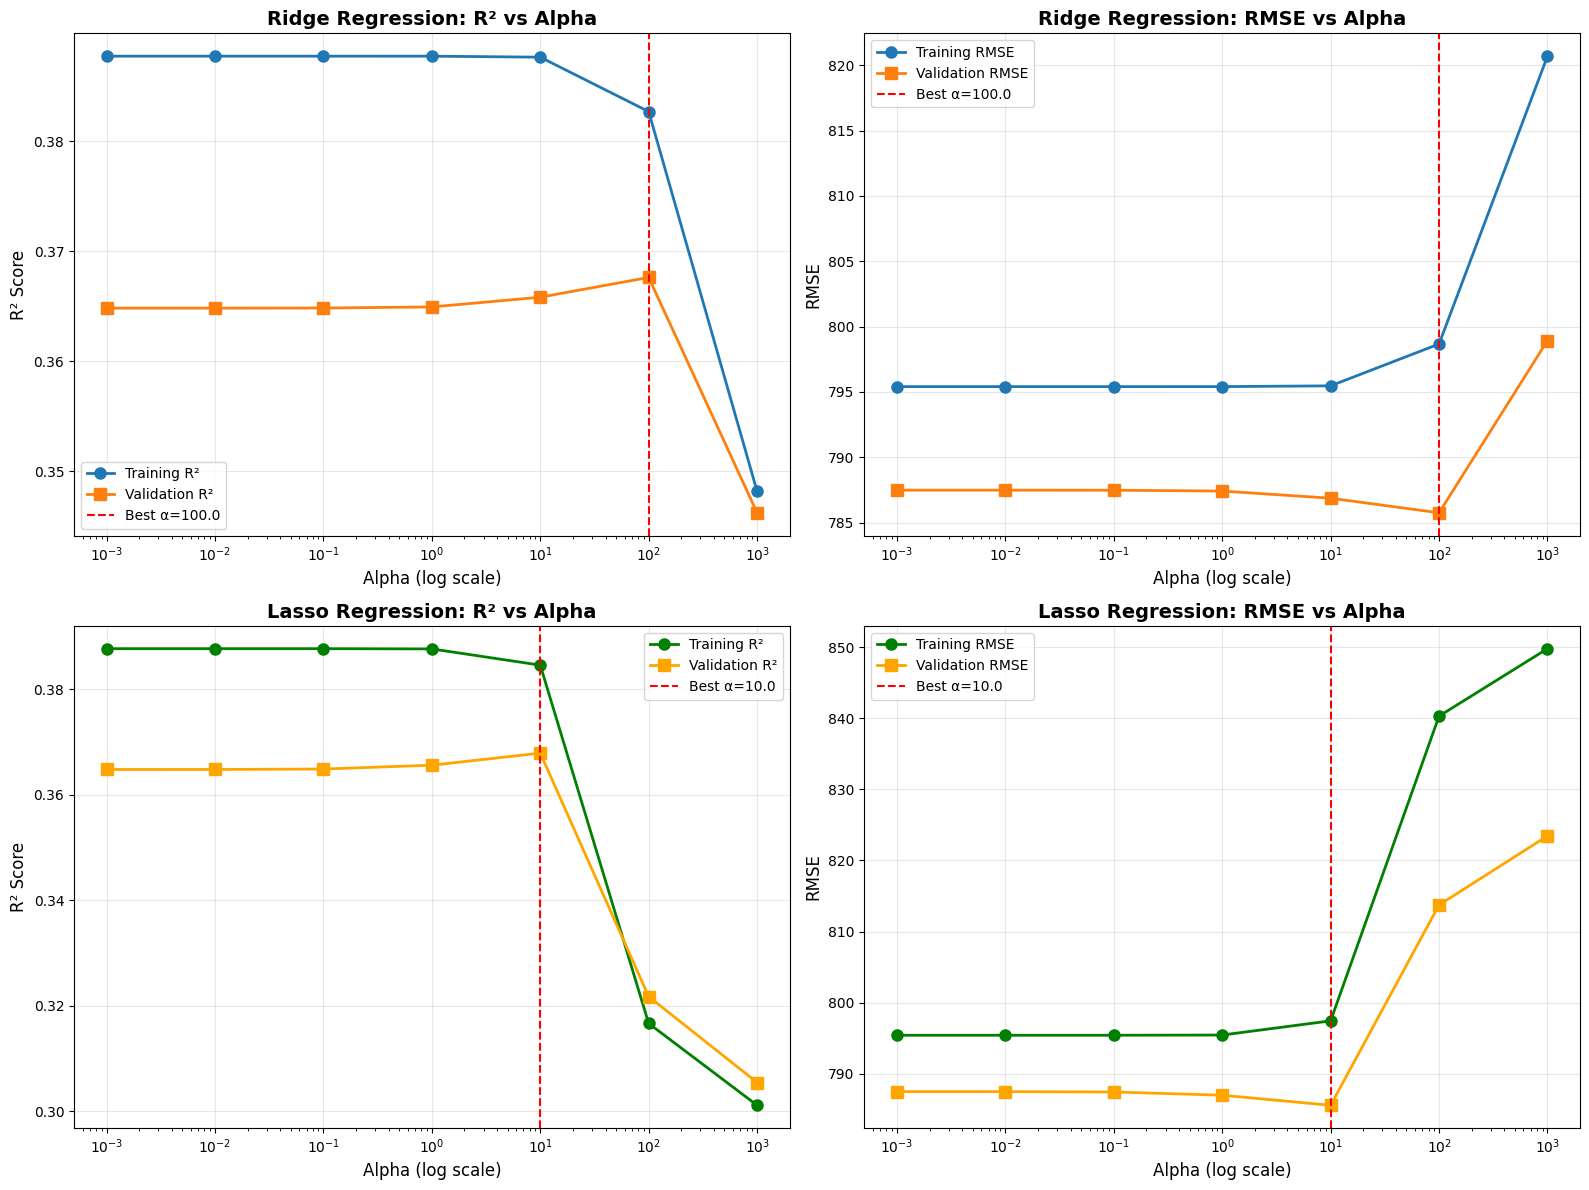

In [27]:
# Visualize Ridge and Lasso performance across different alphas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ridge: R² vs Alpha
axes[0, 0].semilogx(ridge_results_df['alpha'], ridge_results_df['train_r2'], 
                    marker='o', label='Training R²', linewidth=2, markersize=8)
axes[0, 0].semilogx(ridge_results_df['alpha'], ridge_results_df['val_r2'], 
                    marker='s', label='Validation R²', linewidth=2, markersize=8)
axes[0, 0].axvline(x=best_ridge_alpha, color='red', linestyle='--', label=f'Best α={best_ridge_alpha}')
axes[0, 0].set_xlabel('Alpha (log scale)', fontsize=12)
axes[0, 0].set_ylabel('R² Score', fontsize=12)
axes[0, 0].set_title('Ridge Regression: R² vs Alpha', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Ridge: RMSE vs Alpha
axes[0, 1].semilogx(ridge_results_df['alpha'], ridge_results_df['train_rmse'], 
                    marker='o', label='Training RMSE', linewidth=2, markersize=8)
axes[0, 1].semilogx(ridge_results_df['alpha'], ridge_results_df['val_rmse'], 
                    marker='s', label='Validation RMSE', linewidth=2, markersize=8)
axes[0, 1].axvline(x=best_ridge_alpha, color='red', linestyle='--', label=f'Best α={best_ridge_alpha}')
axes[0, 1].set_xlabel('Alpha (log scale)', fontsize=12)
axes[0, 1].set_ylabel('RMSE', fontsize=12)
axes[0, 1].set_title('Ridge Regression: RMSE vs Alpha', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Lasso: R² vs Alpha
axes[1, 0].semilogx(lasso_results_df['alpha'], lasso_results_df['train_r2'], 
                    marker='o', label='Training R²', linewidth=2, markersize=8, color='green')
axes[1, 0].semilogx(lasso_results_df['alpha'], lasso_results_df['val_r2'], 
                    marker='s', label='Validation R²', linewidth=2, markersize=8, color='orange')
axes[1, 0].axvline(x=best_lasso_alpha, color='red', linestyle='--', label=f'Best α={best_lasso_alpha}')
axes[1, 0].set_xlabel('Alpha (log scale)', fontsize=12)
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('Lasso Regression: R² vs Alpha', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Lasso: RMSE vs Alpha
axes[1, 1].semilogx(lasso_results_df['alpha'], lasso_results_df['train_rmse'], 
                    marker='o', label='Training RMSE', linewidth=2, markersize=8, color='green')
axes[1, 1].semilogx(lasso_results_df['alpha'], lasso_results_df['val_rmse'], 
                    marker='s', label='Validation RMSE', linewidth=2, markersize=8, color='orange')
axes[1, 1].axvline(x=best_lasso_alpha, color='red', linestyle='--', label=f'Best α={best_lasso_alpha}')
axes[1, 1].set_xlabel('Alpha (log scale)', fontsize=12)
axes[1, 1].set_ylabel('RMSE', fontsize=12)
axes[1, 1].set_title('Lasso Regression: RMSE vs Alpha', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 23. Decision Tree Regression with Comprehensive Hyperparameter Tuning

In [30]:
from sklearn.tree import DecisionTreeRegressor

print("="*70)
print("DECISION TREE REGRESSION - HYPERPARAMETER TUNING")
print("="*70)
print("\nUsing GridSearchCV for comprehensive hyperparameter optimization...")

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [10, 20, 50, 100, None],
    'criterion': ['squared_error', 'absolute_error'],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.05, 0.1]
}

# Use polynomial features for decision tree as well
print(f"Using Polynomial Features with Degree {int(best_degree)}")
print(f"Training features: {X_train_poly.shape[1]}")

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Perform GridSearchCV
print("\nPerforming GridSearchCV (this may take a few minutes)...")
print(f"Total combinations to test: {5 * 4 * 4 * 5 * 2 * 3 * 5} = {5 * 4 * 4 * 5 * 2 * 3 * 5}")

dt_grid_search = GridSearchCV(
    estimator=dt_regressor,
    param_grid=dt_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train_poly, y_train)

print("\nGridSearchCV completed!")
print(f"Best parameters found: {dt_grid_search.best_params_}")
print(f"Best cross-validation R² score: {dt_grid_search.best_score_:.4f}")

DECISION TREE REGRESSION - HYPERPARAMETER TUNING

Using GridSearchCV for comprehensive hyperparameter optimization...
Using Polynomial Features with Degree 1
Training features: 17

Performing GridSearchCV (this may take a few minutes)...
Total combinations to test: 12000 = 12000
Fitting 5 folds for each of 12000 candidates, totalling 60000 fits

GridSearchCV completed!
Best parameters found: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best cross-validation R² score: 0.5438


## 24. Evaluate Best Decision Tree Model

In [32]:
# Get the best model from GridSearchCV
best_dt_model = dt_grid_search.best_estimator_

# Make predictions
y_train_pred_dt = best_dt_model.predict(X_train_poly)
y_val_pred_dt = best_dt_model.predict(X_val_poly)

# Calculate metrics
dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_val_r2 = r2_score(y_val, y_val_pred_dt)
dt_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
dt_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_dt))
dt_train_mae = mean_absolute_error(y_train, y_train_pred_dt)
dt_val_mae = mean_absolute_error(y_val, y_val_pred_dt)

print("="*70)
print("DECISION TREE REGRESSION - FINAL PERFORMANCE METRICS")
print("="*70)

print("\nBest Hyperparameters:")
for param, value in dt_grid_search.best_params_.items():
    print(f"  {param}: {value}")

print("\nTRAINING SET METRICS:")
print(f"  R² Score:  {dt_train_r2:.4f}")
print(f"  RMSE:      {dt_train_rmse:.2f}")
print(f"  MAE:       {dt_train_mae:.2f}")

print("\nVALIDATION SET METRICS:")
print(f"  R² Score:  {dt_val_r2:.4f}")
print(f"  RMSE:      {dt_val_rmse:.2f}")
print(f"  MAE:       {dt_val_mae:.2f}")

print(f"\nOverfitting Gap: {abs(dt_train_r2 - dt_val_r2):.4f}")

print("\n" + "="*70)
print(f"FINAL SCORE (Validation R²): {dt_val_r2:.4f}")
print("="*70)

DECISION TREE REGRESSION - FINAL PERFORMANCE METRICS

Best Hyperparameters:
  ccp_alpha: 0.0
  criterion: squared_error
  max_depth: 5
  max_features: None
  max_leaf_nodes: 10
  min_samples_leaf: 1
  min_samples_split: 20

TRAINING SET METRICS:
  R² Score:  0.5673
  RMSE:      668.67
  MAE:       355.90

VALIDATION SET METRICS:
  R² Score:  0.5850
  RMSE:      636.51
  MAE:       338.47

Overfitting Gap: 0.0177

FINAL SCORE (Validation R²): 0.5850


## 24.1 Generate Submission for Tuned Decision Tree

In [36]:


print("\n" + "="*70)
print("GENERATING SUBMISSION FILE FOR DECISION TREE")
print("="*70)

# 1. Transform the preprocessed test data using the polynomial features
# 'poly_features' was defined in Section 19
# 'test_clean' is ready from Section 7
print("Transforming test data with polynomial features...")
X_test_poly = poly_features.transform(test_clean)
print(f"Transformed test data to {X_test_poly.shape[1]} polynomial features.")

# 2. Predict using the best Decision Tree model
# 'best_dt_model' was defined in Section 24
test_predictions_dt = best_dt_model.predict(X_test_poly)

# 3. Create the submission DataFrame
# Use the 'Hospital_Id' from the original 'test_df'
submission_dt = pd.DataFrame({
    'Hospital_Id': test_df['Hospital_Id'], 
    'Transport_Cost': test_predictions_dt
})

# 4. Save to CSV
submission_dt.to_csv('submission_decision_tree.csv', index=False)

print("✅ submission_decision_tree.csv created successfully!")
print(submission_dt.head())
print("="*70)


GENERATING SUBMISSION FILE FOR DECISION TREE
Transforming test data with polynomial features...
Transformed test data to 17 polynomial features.
✅ submission_decision_tree.csv created successfully!
            Hospital_Id  Transport_Cost
0          fffe33003400      468.053814
1  fffe3700330036003600      195.953209
2  fffe3300390038003400     1339.540865
3      fffe310030003900      195.953209
4  fffe3700330031003200      522.077445


## 25. Visualize Decision Tree Performance

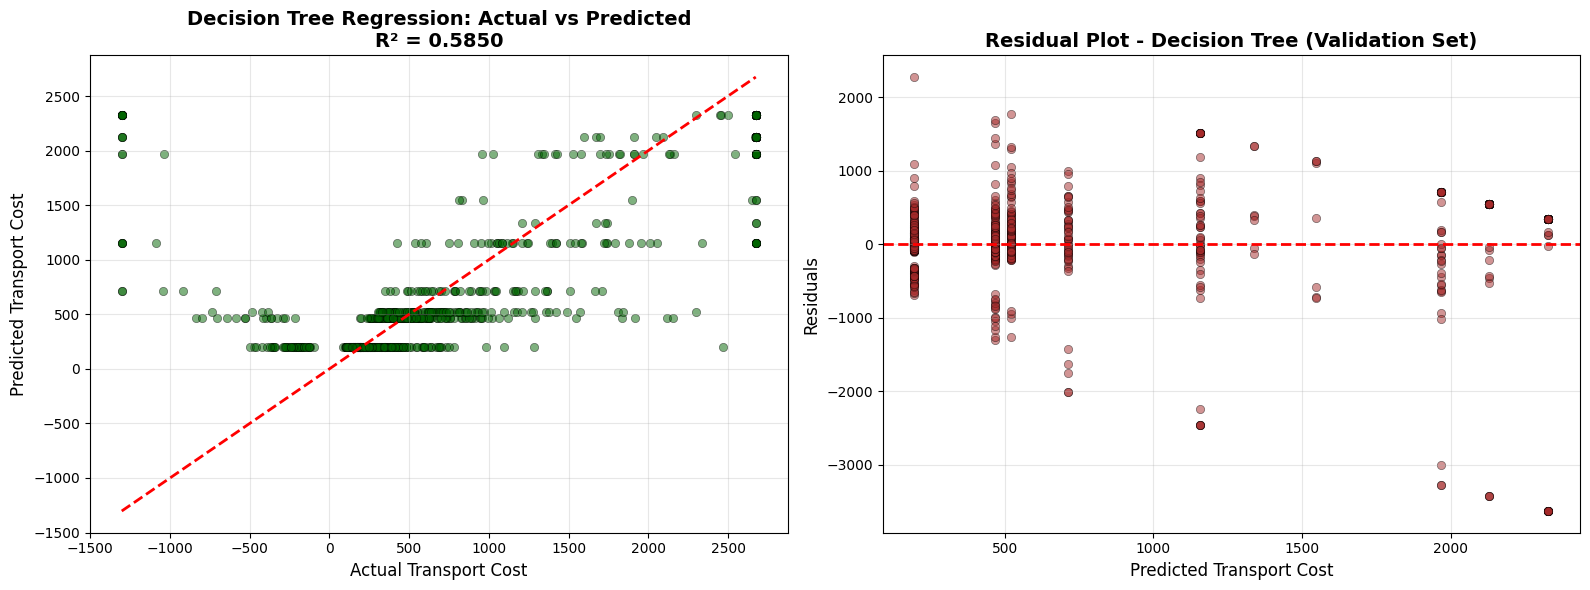


Residual Statistics:
  Mean of Residuals:     36.5230
  Std of Residuals:      635.77
  Min Residual:          -3630.84
  Max Residual:          2273.54


In [33]:
# Visualize Decision Tree predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot - Validation Set
axes[0].scatter(y_val, y_val_pred_dt, alpha=0.5, edgecolors='k', linewidth=0.5, color='darkgreen')
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Transport Cost', fontsize=12)
axes[0].set_ylabel('Predicted Transport Cost', fontsize=12)
axes[0].set_title(f'Decision Tree Regression: Actual vs Predicted\nR² = {dt_val_r2:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals_dt = y_val - y_val_pred_dt
axes[1].scatter(y_val_pred_dt, residuals_dt, alpha=0.5, edgecolors='k', linewidth=0.5, color='brown')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Transport Cost', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot - Decision Tree (Validation Set)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print residual statistics
print("\nResidual Statistics:")
print(f"  Mean of Residuals:     {residuals_dt.mean():.4f}")
print(f"  Std of Residuals:      {residuals_dt.std():.2f}")
print(f"  Min Residual:          {residuals_dt.min():.2f}")
print(f"  Max Residual:          {residuals_dt.max():.2f}")

## 26. Analyze Top GridSearch Results

In [34]:
# Analyze GridSearchCV results
cv_results = pd.DataFrame(dt_grid_search.cv_results_)

# Get top 10 parameter combinations
top_10_results = cv_results.nlargest(10, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]

print("="*70)
print("TOP 10 DECISION TREE HYPERPARAMETER COMBINATIONS")
print("="*70)

for idx, row in top_10_results.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Mean CV R² Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"  Parameters:")
    for param, value in row['params'].items():
        print(f"    {param}: {value}")

# Analyze parameter importance
print("\n" + "="*70)
print("PARAMETER ANALYSIS")
print("="*70)

# Show distribution of best parameters
best_params = dt_grid_search.best_params_
print("\nOptimal Parameter Values:")
print(f"  max_depth:          {best_params['max_depth']}")
print(f"  min_samples_split:  {best_params['min_samples_split']}")
print(f"  min_samples_leaf:   {best_params['min_samples_leaf']}")
print(f"  max_leaf_nodes:     {best_params['max_leaf_nodes']}")
print(f"  criterion:          {best_params['criterion']}")
print(f"  max_features:       {best_params['max_features']}")
print(f"  ccp_alpha:          {best_params['ccp_alpha']}")

TOP 10 DECISION TREE HYPERPARAMETER COMBINATIONS

Rank 1:
  Mean CV R² Score: 0.5438 (±0.0278)
  Parameters:
    ccp_alpha: 0.0
    criterion: squared_error
    max_depth: 5
    max_features: None
    max_leaf_nodes: 10
    min_samples_leaf: 1
    min_samples_split: 20

Rank 1:
  Mean CV R² Score: 0.5438 (±0.0278)
  Parameters:
    ccp_alpha: 0.0
    criterion: squared_error
    max_depth: 5
    max_features: None
    max_leaf_nodes: 10
    min_samples_leaf: 2
    min_samples_split: 20

Rank 1:
  Mean CV R² Score: 0.5438 (±0.0278)
  Parameters:
    ccp_alpha: 0.0
    criterion: squared_error
    max_depth: 5
    max_features: None
    max_leaf_nodes: 10
    min_samples_leaf: 5
    min_samples_split: 20

Rank 1:
  Mean CV R² Score: 0.5438 (±0.0278)
  Parameters:
    ccp_alpha: 0.0
    criterion: squared_error
    max_depth: 5
    max_features: None
    max_leaf_nodes: 10
    min_samples_leaf: 10
    min_samples_split: 2

Rank 1:
  Mean CV R² Score: 0.5438 (±0.0278)
  Parameters:
    ccp